<h1><center>Pokémon Go: Clustering, Regression, and Random Forest</center></h1>
<center>Author: Sean Cannon</center>

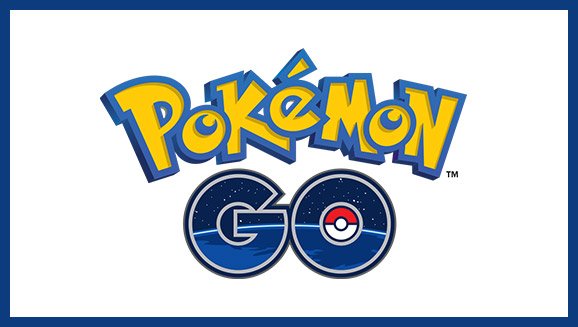

Pokémon Go is a 2016 mobile game that allows players to catch pokémon and battle in real locations. This analysis seeks to use pokémon statistics in conjunction with data science to explore popular machine learning techniques like clustering, regression, and random forest models.

This analysis uses the [pokémon stats](https://www.kaggle.com/datasets/calebreigada/pokemon) dataset from Kaggle. Here are the variables included in the subset used for this analysis:

- number - The number of the pokémon in the pokédex
- pokemon_name - The name of the pokémon
- main_type - The primary type of the pokémon
- region - Region where pokémon first appeared in the pokémon games
- attack - Pokémon base attack stat in pokémon Go
- defense - Pokémon base defense stat in pokémon Go
- stamina - Pokémon base stamina stat in pokémon Go
- shiny - Shiny form available?
- shadow - Shadow form available?

In [607]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from IPython.display import display

# sklearn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# silhouette score
from sklearn.metrics import silhouette_score

# set random seed
RSEED = 50

%matplotlib inline

# to suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

The dataset has 770 pokémon of varying types and stats. Some have shiny or shadow cards available, which are more rare forms of the card. Separating the columns based on integer and object data types will help with plotting and analysis.

In [608]:
# load the 'matches' dataset from csv
columns = ['number','pokemon_name','main_type','region','attack','defense','stamina','shiny','shadow']
pokemon = pd.read_csv('pokemon.csv', usecols = columns)

def shape(x):
    rows, cols = x.shape
    print(f"There are {rows} rows and {cols} columns in the dataset")

# observe the rows and columns
shape(pokemon)

# view the dataset with head()
pokemon.head()

There are 770 rows and 9 columns in the dataset


,number,pokemon_name,main_type,region,attack,defense,stamina,shiny,shadow
0,1,Bulbasaur,Grass,Kanto,118,111,128,Yes,Yes
1,2,Ivysaur,Grass,Kanto,151,143,155,Yes,Yes
2,3,Venusaur,Grass,Kanto,198,189,190,Yes,Yes
3,4,Charmander,Fire,Kanto,116,93,118,Yes,Yes
4,5,Charmeleon,Fire,Kanto,158,126,151,Yes,Yes


In [609]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   number        770 non-null    int64 
 1   pokemon_name  770 non-null    object
 2   main_type     770 non-null    object
 3   region        770 non-null    object
 4   attack        770 non-null    int64 
 5   defense       770 non-null    int64 
 6   stamina       770 non-null    int64 
 7   shiny         770 non-null    object
 8   shadow        770 non-null    object
dtypes: int64(4), object(5)
memory usage: 54.3+ KB


In [610]:
pokemon.describe()

,number,attack,defense,stamina
count,770.000000,770.000000,770.000000,770.000000
mean,387.740260,161.861039,142.588312,169.062338
std,226.559919,55.817370,50.171027,44.214794
min,1.000000,17.000000,32.000000,1.000000
25%,193.250000,118.000000,102.250000,137.000000
50%,385.500000,161.000000,139.000000,163.000000
75%,577.750000,204.000000,176.000000,190.000000
max,893.000000,345.000000,396.000000,496.000000


**Duplicates and missing values**

There are no duplicates or missing values in the 770 fields that are observed.

In [611]:
# check for duplicates
print("Number of duplicates in the pokémon dataset:", pokemon.duplicated().sum())

Number of duplicates in the pokémon dataset: 0


In [612]:
# check for missing
pokemon.isnull().sum()

number          0
pokemon_name    0
main_type       0
region          0
attack          0
defense         0
stamina         0
shiny           0
shadow          0
dtype: int64

In [613]:
# Sort into lists based on datatypes
float_col=[]
object_col=[]
int_col=[]
for col in list(pokemon.columns):
    if pokemon[col].dtype == 'int64':
        int_col.append(col)
    elif pokemon[col].dtype == 'float64':
        float_col.append(col)
    else:
        object_col.append(col)
        
continuous = pokemon[int_col]
objects = pokemon[object_col]

del continuous['number']

**Visualization**

Below are histograms and box and whisker plots for all of the continuous variables in the dataset. Attack seems somewhat normally distributed, whereas defense and stamina are right skewed. There are some outliers in the dataset, but nothing too concerning.

attack
Skew : 0.09


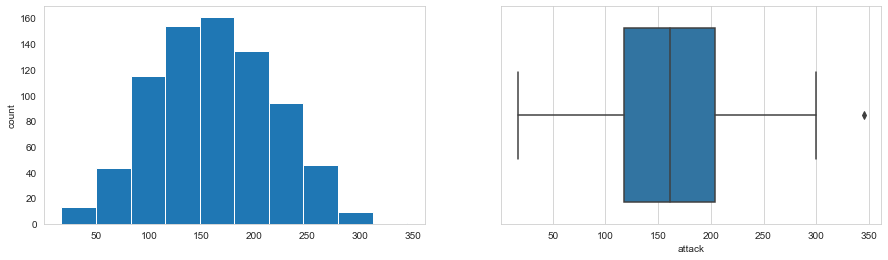

defense
Skew : 0.57


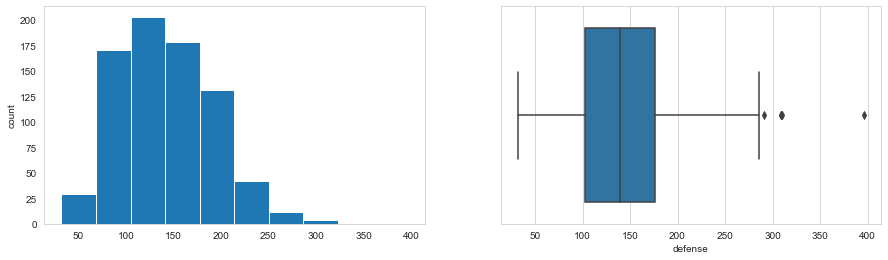

stamina
Skew : 1.58


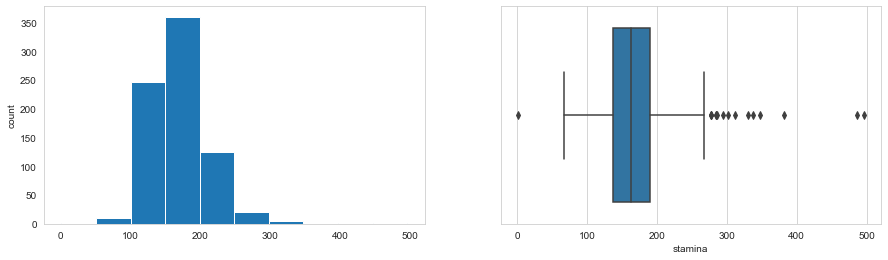

In [614]:
for col in continuous.columns[0:]:
    print(col)
    print('Skew :',round(continuous[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    continuous[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=continuous[col])
    plt.show()

Water type pokémon appear the most frequently, where flying type occur the least frequently. Unova is the most frequenly observed region, where Galar was the least frequently observed region. Cards with shiny variants appear more often than ones with shadow variants.

In [615]:
# shorten the type variable in objects dataframe to 3 letters
objects['main_type'] = objects['main_type'].astype(str).str[0:3]
#del objects['main_type']
objects.head()

,pokemon_name,main_type,region,shiny,shadow
0,Bulbasaur,Gra,Kanto,Yes,Yes
1,Ivysaur,Gra,Kanto,Yes,Yes
2,Venusaur,Gra,Kanto,Yes,Yes
3,Charmander,Fir,Kanto,Yes,Yes
4,Charmeleon,Fir,Kanto,Yes,Yes


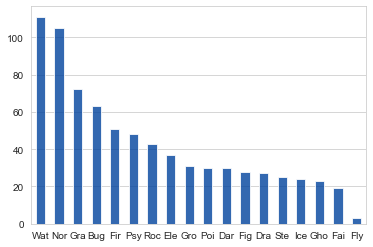

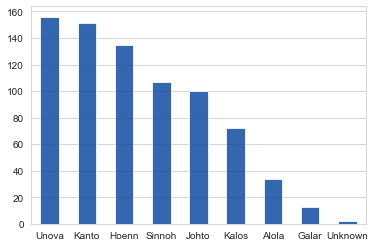

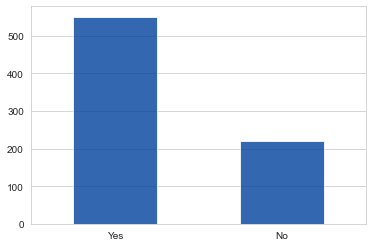

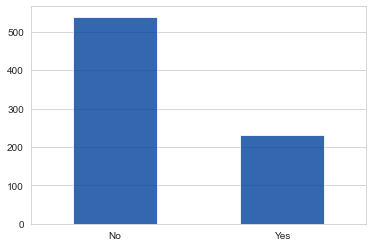

In [616]:
sns.set_style("whitegrid")

for col in objects.columns[1:]:
    objects[col].value_counts().plot(kind='bar', rot = 0, alpha=0.8, color='#00429d')
    ax = plt.subplot(111)
    ax.spines[['top', 'right','left','bottom']].set_visible(True)
    #ax.grid(False)
    ax.grid(axis='x')
    ax.set_facecolor("white")
    plt.show()

**Pairplot and correlation**

In addition, most of the continuous variables appear somewhat positively correlated with one another. Histograms with more properly formatted bins give a better sense of the distribution for each variable.

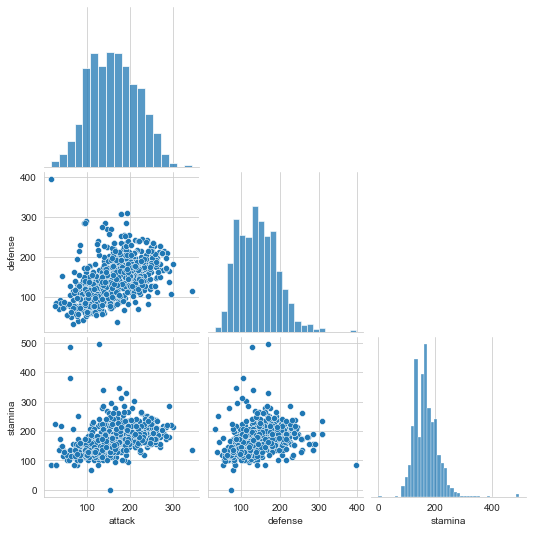

In [617]:
# pairplot
sns.pairplot(continuous, corner=True)

Text(0.5, 1.0, 'Correlation Matrix')

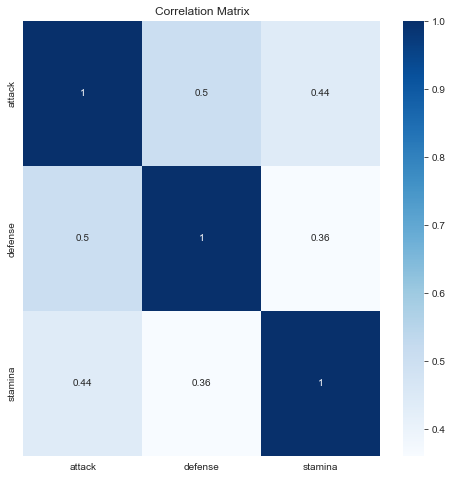

In [618]:
# plot seaborn heatmap
plt.figure(figsize=(8,8))
sns.heatmap(continuous.corr(), annot=True, cmap='Blues').set_title('Correlation Matrix') #cmap='viridis'

## K-means clustering

**Scaling and choosing number of clusters**

Standardizing the data will be important as this dataset contains mixed numeric fields.

In [619]:
#Scaling the data and storing the output as a new dataframe
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(continuous), columns=continuous.columns)

print(data_scaled.head())

#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

     attack   defense   stamina
0 -0.786306 -0.630022 -0.929305
1 -0.194708  0.008211 -0.318253
2  0.647871  0.925671  0.473852
3 -0.822161 -0.989028 -1.155621
4 -0.069218 -0.330850 -0.408779


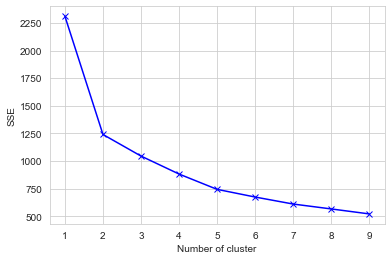

In [620]:
#Empty dictionary to store the SSE for each value of k
sse = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

#Elbow plot
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

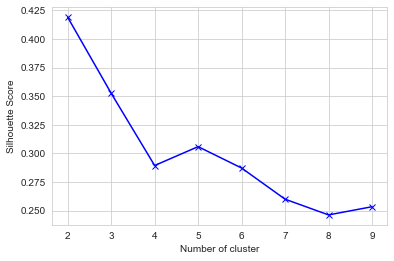

In [621]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

Based on SSE and sillhouette score, anywhere from 2-5 clusters could work for this analyis. Here, visual trial and error on the number of appropriate clusters will work well. I've chosen to use three clusters.

In [622]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_scaled)

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['KMeans_Labels'] = kmeans.predict(data_scaled)
continuous['KMeans_Labels'] = kmeans.predict(data_scaled)

continuous['KMeans_Labels'].value_counts()

1    349
0    320
2    101
Name: KMeans_Labels, dtype: int64

In [623]:
#Calculating mean and median of the original data for each label
mean = continuous.groupby('KMeans_Labels').mean()
median = continuous.groupby('KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
attack,201.812500,117.071633,190.049505,200.0,117.0,188.0
defense,178.350000,103.504298,164.336634,175.5,99.0,162.0
stamina,176.053125,140.515759,245.554455,177.0,137.0,233.0


**Visualize the labels**

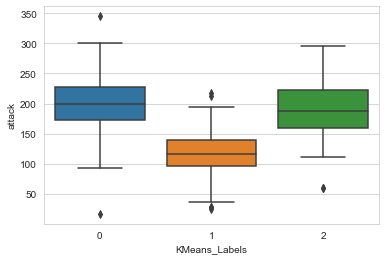

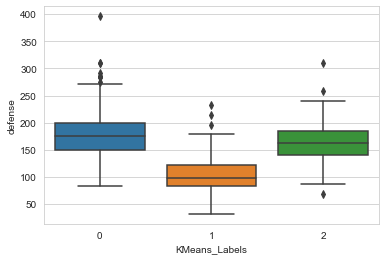

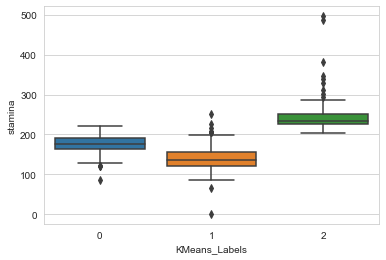

In [624]:
almonds = ['attack','defense','stamina']

for col in almonds:
    sns.boxplot(x = 'KMeans_Labels', y = col, data = continuous)
    plt.show()

**Visualize the clusters**

Visualizing results of the k-means clustering shows stamina plotted against attack/defense. Results are somewhat muddied, but there are 3 clusters in the left, right, and top of the scatterplot.

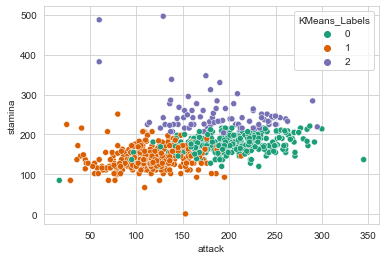

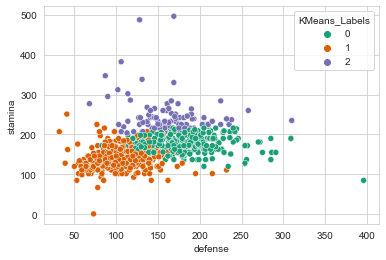

In [625]:
walnuts = ['attack','defense']

for col in walnuts:
    sns.scatterplot(x = col, y = 'stamina',data = continuous ,hue='KMeans_Labels', palette='Dark2')
    plt.show()

## Linear regression

**Split the data into testing and training datasets**

In [626]:
# load the test and train datasets: 70-30 split
train_df = pd.read_excel('poktrain.xlsx')
test_df = pd.read_excel('poktest.xlsx')

train_df = train_df.drop(['number', 'pokemon_name','main_type','region'], axis=1)
test_df = test_df.drop(['number', 'pokemon_name','main_type','region'], axis=1)

pd.get_dummies(train_df)

,attack,defense,stamina,shiny_No,shiny_Yes,shadow_No,shadow_Yes
0,118,111,128,0,1,0,1
1,151,143,155,0,1,0,1
2,198,189,190,0,1,0,1
3,116,93,118,0,1,0,1
4,158,126,151,0,1,0,1
...,...,...,...,...,...,...,...
528,154,85,155,1,0,1,0
529,255,129,242,1,0,1,0
530,114,163,230,0,1,1,0
531,134,87,181,0,1,1,0


In [627]:
train_df.head()

,attack,defense,stamina,shiny,shadow
0,118,111,128,Yes,Yes
1,151,143,155,Yes,Yes
2,198,189,190,Yes,Yes
3,116,93,118,Yes,Yes
4,158,126,151,Yes,Yes


In [628]:
test_df.head()

,attack,defense,stamina,shiny,shadow
0,243,158,233,Yes,No
1,98,78,137,Yes,No
2,128,109,181,Yes,No
3,188,150,233,Yes,No
4,172,160,260,Yes,No


**Visualize the continuous variables**

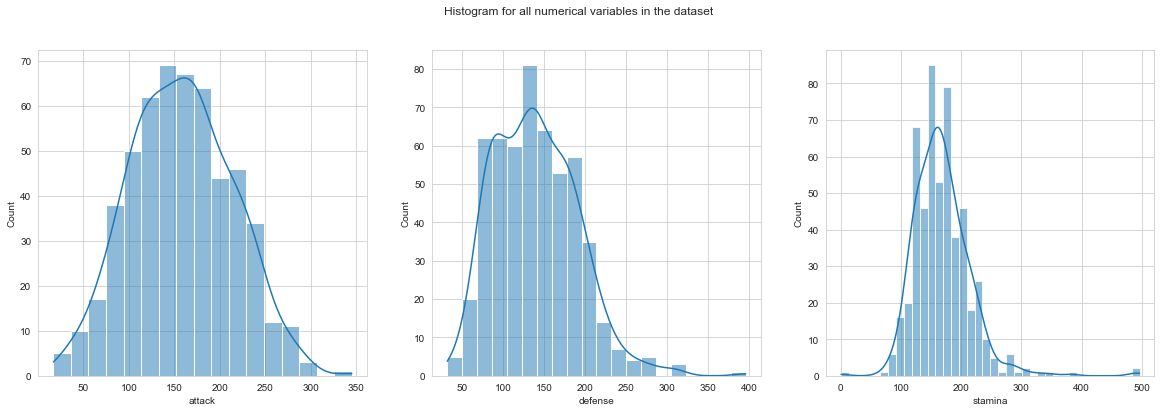

In [629]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  
fig.suptitle('Histogram for all numerical variables in the dataset')
  
sns.histplot(x='attack', data=train_df, kde=True, ax=axes[0]);
sns.histplot(x='defense', data=train_df, kde=True, ax=axes[1]);
sns.histplot(x='stamina', data=train_df, kde=True, ax=axes[2]);

In [637]:
# we are removing the outcome variable from the feature set and also the variable Outlet_Establishment_Year as we have created
# a new variable Outlet_Age
train_features = train_df.drop(['shiny'], axis=1)

# and then we are extracting the outcome variable separately
train_target = train_df['shiny']
train_target = pd.get_dummies(train_target, drop_first=True)
train_target.rename(columns = {'Yes':'shiny'}, inplace = True)

# in linear based models it is mandatory to create dummy variables for the categorical variables
train_features = pd.get_dummies(train_features, drop_first=True)
train_features.head()

# creating an instance of the MinMaxScaler
scaler = MinMaxScaler()

# applying fit_transform on the training features data
train_features_scaled = scaler.fit_transform(train_features)
#test_features_scaled = scaler.transform(test_features)


# the above scaler returns the data in array format, below we are converting back to pandas dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, index=train_features.index, columns=train_features.columns)
train_features_scaled.head()

,attack,defense,stamina,shadow_Yes
0,0.307927,0.217033,0.256566,1.0
1,0.408537,0.304945,0.311111,1.0
2,0.551829,0.431319,0.381818,1.0
3,0.301829,0.167582,0.236364,1.0
4,0.429878,0.258242,0.303030,1.0


In [638]:
# here we are adding the intercept term
train_features_scaled = sm.add_constant(train_features_scaled)

# calling the OLS algorithm on the train features and target variable
ols_model_0 = sm.OLS(train_target, train_features_scaled)

# fitting the model
ols_res_0 = ols_model_0.fit()

$$shiny = \beta_0+\beta_1attack+\beta_2defense+\beta_3stamina+\beta_4shadow$$

Above is the linear probability model estimated using OLS. Results from the linear probability model regression results show a very low R-squared, and mostly insignificant p-values (with the exception of shadow). It appears that a card having a shadow variant results in about a 10 percentage point increase in the probability that the card also has a shiny variant. It makes sense that more rare, sought after pokémon might have both forms of the card. 

In [639]:
print(ols_res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                  shiny   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.301
Date:                Wed, 15 Jun 2022   Prob (F-statistic):            0.00197
Time:                        15:03:29   Log-Likelihood:                -95.552
No. Observations:                 533   AIC:                             201.1
Df Residuals:                     528   BIC:                             222.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8855      0.051     17.478      0.0

## Tree-based models and random forest

In [661]:
df = pd.read_csv('pokemon.csv').sample(770, random_state = RSEED)
#df.drop(['number','pokemon_name'], axis=1)
del df['number']
del df['pokemon_name']
# must turn categorical variables into dummies
df = pd.get_dummies(df, drop_first=True)
df.head()

,attack,defense,stamina,main_type_Dark,main_type_Dragon,main_type_Electric,main_type_Fairy,main_type_Fighting,main_type_Fire,main_type_Flying,...,region_Galar,region_Hoenn,region_Johto,region_Kalos,region_Kanto,region_Sinnoh,region_Unknown,region_Unova,shiny_Yes,shadow_Yes
314,186,131,137,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
636,264,189,198,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
127,198,183,181,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
552,229,158,216,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
118,175,147,190,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [641]:
df = df.select_dtypes('number')

In [642]:
df['shiny_Yes'] = df['shiny_Yes'].replace({2: 0})
df = df.loc[df['shiny_Yes'].isin([0, 1])].copy()
df = df.rename(columns = {'shiny_Yes': 'label'})
df['label']=1-df['label']
df['label'].value_counts()

0    551
1    219
Name: label, dtype: int64

**Split the labels into training and testing datasets**

Use `train_test_split` to split the data into 70-30 training and testing datasets.

In [643]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

As a contingency this was included. However, this dataset has no missing values, so nothing needs to be imputed.

In [644]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [645]:
train.shape

(539, 29)

In [646]:
test.shape

(231, 29)

**Train the decision tree**

In [647]:
# Train tree
tree = DecisionTreeClassifier(random_state=RSEED)

tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 193 nodes with maximum depth 15.


In [648]:
print(tree.predict_proba(train))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [649]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

**Evaluate the performance of the decision tree**

Based on the perfect ROC AUC score, this model has been significantly overfitted to the training data.

In [650]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.7575757575757576


In [651]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


In [652]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [653]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({0.0: 169, 1.0: 62})
Counter({0: 169, 1: 62})


**ROC Curves**

As we can see based on the below ROC curves, the model has been overfit to the training data. The single decision tree outperforms the baseline model.

Recall Baseline: 1.0 Test: 0.64 Train: 1.0
Precision Baseline: 0.29 Test: 0.68 Train: 1.0
Roc Baseline: 0.5 Test: 0.76 Train: 1.0


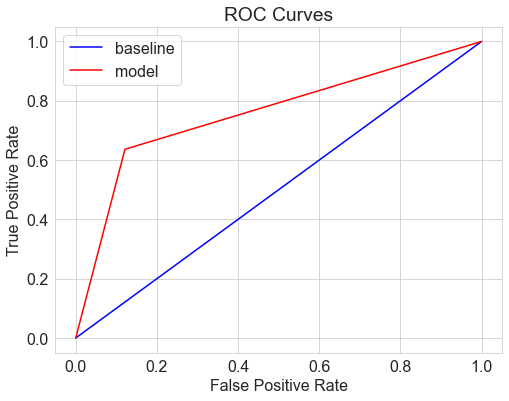

In [654]:
evaluate_model(predictions, probs, train_predictions, train_probs)

**Confustion Matrix**

In [662]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[145  20]
 [ 24  42]]


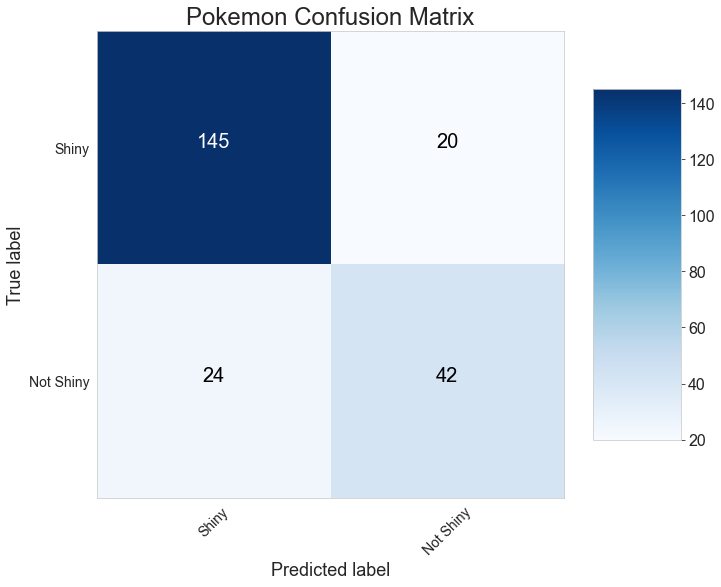

In [674]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = [ 'Shiny', 'Not Shiny'],
                      title = 'Pokemon Confusion Matrix',cmap=plt.cm.Blues)

The confusion matrix shows that the single decision tree was fairly accurate at predicting whether or not a pokémon will have a shiny card variant.

Interestingly, region Kalos was identified as being the most important feature to the decision tree. It even ranks above the defense, attack, and stamina statistics (which are also important features).

In [676]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
23,region_Kalos,0.172280
1,defense,0.162022
0,attack,0.126001
2,stamina,0.118838
27,region_Unova,0.106285


[Text(0.5648148148148148, 0.9, 'region_Kalos <= 0.5\ngini = 0.407\nsamples = 539\nvalue = [386, 153]'),
 Text(0.2962962962962963, 0.7, 'region_Unova <= 0.5\ngini = 0.347\nsamples = 488\nvalue = [379, 109]'),
 Text(0.14814814814814814, 0.5, 'region_Galar <= 0.5\ngini = 0.237\nsamples = 372\nvalue = [321, 51]'),
 Text(0.07407407407407407, 0.3, 'shadow_Yes <= 0.5\ngini = 0.21\nsamples = 361\nvalue = [318, 43]'),
 Text(0.037037037037037035, 0.1, '\n  (...)  \n'),
 Text(0.1111111111111111, 0.1, '\n  (...)  \n'),
 Text(0.2222222222222222, 0.3, 'defense <= 196.0\ngini = 0.397\nsamples = 11\nvalue = [3, 8]'),
 Text(0.18518518518518517, 0.1, '\n  (...)  \n'),
 Text(0.25925925925925924, 0.1, '\n  (...)  \n'),
 Text(0.4444444444444444, 0.5, 'main_type_Ground <= 0.5\ngini = 0.5\nsamples = 116\nvalue = [58, 58]'),
 Text(0.37037037037037035, 0.3, 'stamina <= 183.5\ngini = 0.498\nsamples = 108\nvalue = [57, 51]'),
 Text(0.3333333333333333, 0.1, '\n  (...)  \n'),
 Text(0.4074074074074074, 0.1, '\n  (.

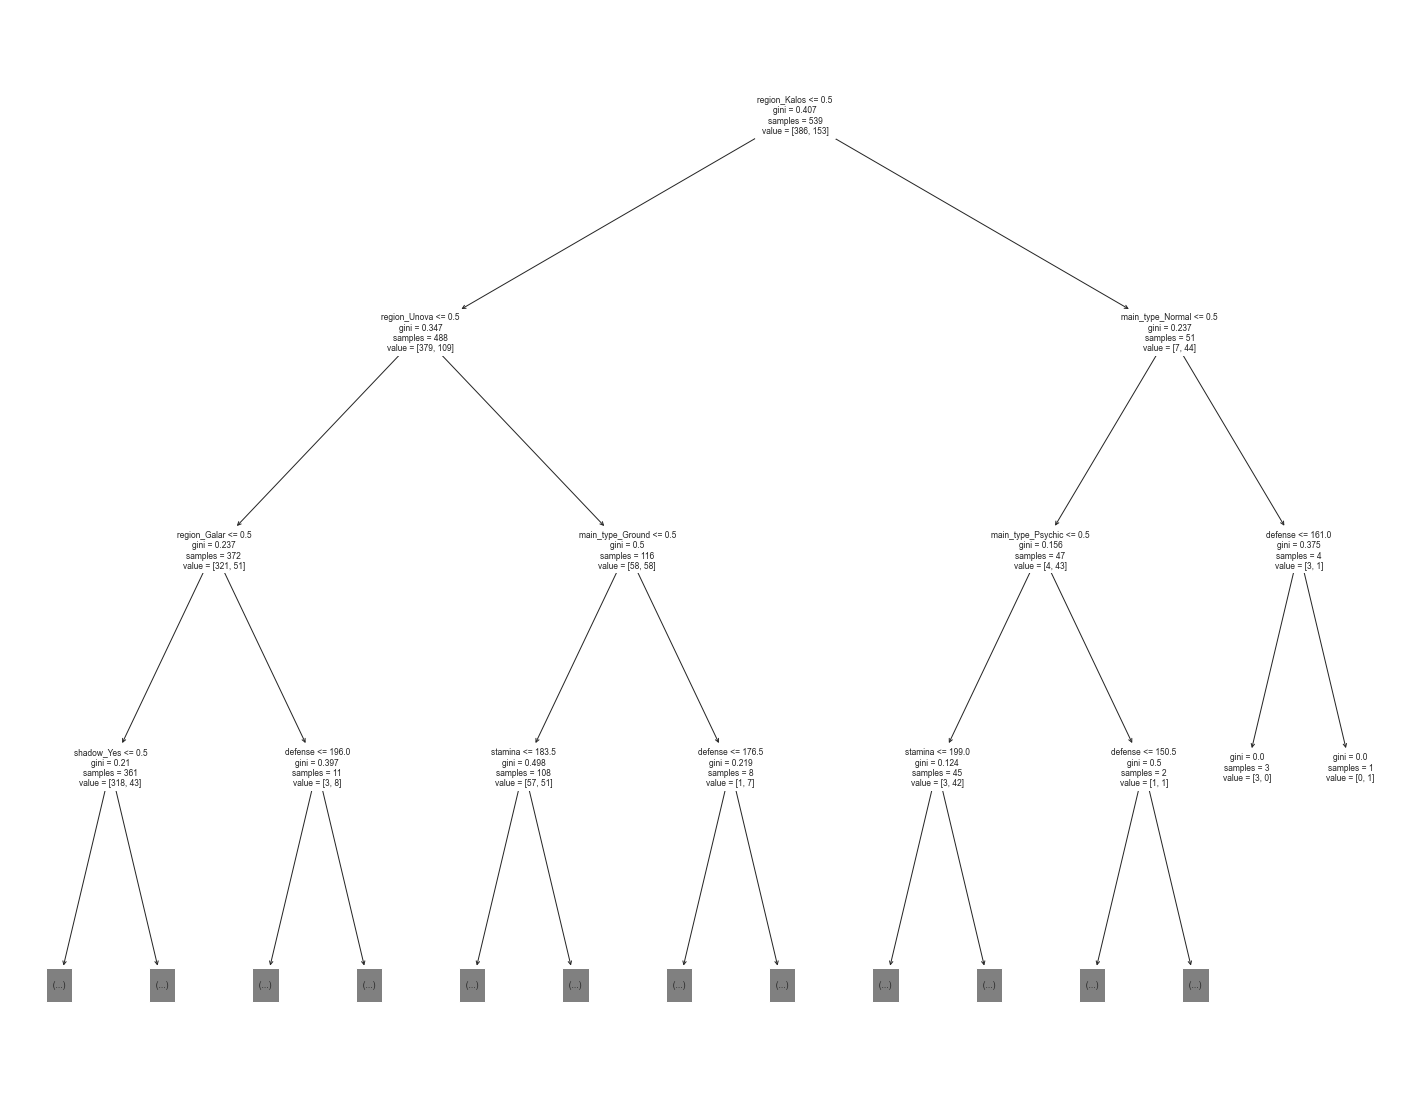

In [656]:
import subprocess
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from PIL import Image
#from subprocess import check_call
# Save tree as dot file
#export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
#                feature_names = features, max_depth = 6,
#                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
#subprocess.call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

#tree.export_graphviz(model_name,'m1_ent.dot',filled=True,feature_names=features,
#                     class_names= classes)

#convert dot into image
#subprocess.check_call(['dot','-Tpng','tree_real_data.dot','-0','tree_real_data.png'])

# Visualize
#Image(filename='tree_real_data.png')
fig = plt.figure(figsize=(25,20))
plot_tree(tree, max_depth=3, feature_names = features)

The above decision tree has many nodes. It's interesting to see how the tree filters based on various features found in the data. Below we will expand this into a random forest model, which has reduced variance when compared to a single decision tree. This model has the benefit of being an ensemble of many trees (in this case 100), where it will average the predictions into a final decision.

In [666]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1,
                              class_weight='balanced')

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(class_weight='balanced', max_features='sqrt', n_jobs=-1,
                       random_state=50, verbose=1)

In [667]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 224
Average maximum depth 23


In [668]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


**ROC curves**

This model has still overfitted to the training data, but performs better during testing. Predictively, this random forest model outperforms just a single decision tree, which is what to expect from an ensemble model.

Recall Baseline: 1.0 Test: 0.65 Train: 1.0
Precision Baseline: 0.29 Test: 0.78 Train: 1.0
Roc Baseline: 0.5 Test: 0.91 Train: 1.0


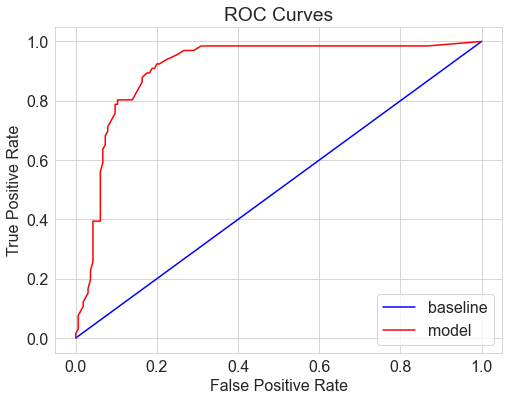

In [671]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

**Confusion Matrix**

Confusion matrix, without normalization
[[153  12]
 [ 23  43]]


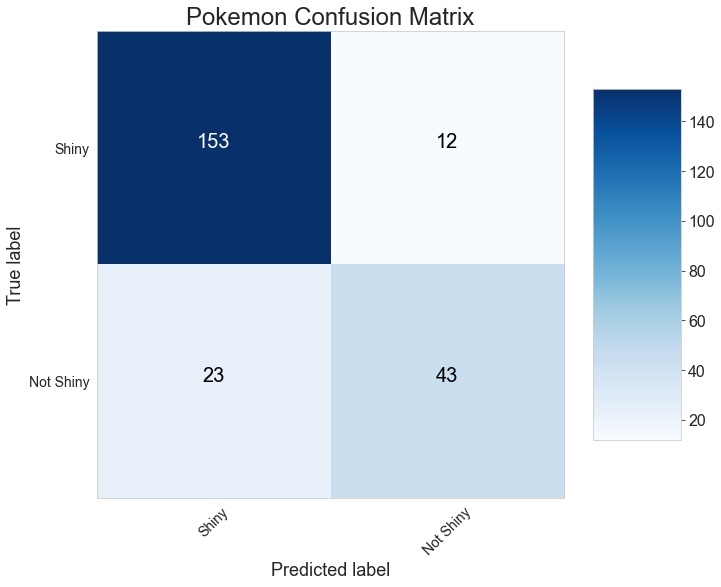

In [673]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = [ 'Shiny', 'Not Shiny'],
                      title = 'Pokemon Confusion Matrix',cmap=plt.cm.Blues)

This confusion matrix is an improvement over the single decision tree, with the random forest being more accurate on the testing dataset.

In [675]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
0,attack,0.135155
1,defense,0.125346
2,stamina,0.115629
24,region_Kanto,0.101987
28,shadow_Yes,0.089321
23,region_Kalos,0.078342
22,region_Johto,0.067831
21,region_Hoenn,0.044498
27,region_Unova,0.042334
25,region_Sinnoh,0.035213


Attack, defense, and stamina have overtaken the regions as the most important features in the random forest model. Shadow has also now made it into the list of the most important features.

## Conclusion

Overall, it was really interesting to see how various data science models functioned on a fun, simple dataset. Specifically, the random forest model seems like it could be applied to many different areas and was surprisingly easy to set up. In hindsight, it would have been better to use a logistic regression as opposed to OLS, as it is generally better than LPM for modeling binary response variables. Finally, while the application of clustering in this dataset may not have been particularly interesting, knowing how to use various clustering algorithms will be useful moving forward.